In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport

from joblib import dump

from scipy.stats import ks_2samp
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc




In [2]:
# Loading the CSV file as a dataframe
diabetes_df = pd.read_csv('./data/diabetes_data_complete.csv')

In [3]:
# Showing the dataframe dimensions
diabetes_df.shape

(100241, 44)

In [4]:
# Showing the column data types
diabetes_df.dtypes

Unnamed: 0                   int64
encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide         

In [5]:
# Showing the top 5 rows
diabetes_df.head()

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [6]:
encoder = OrdinalEncoder()

diabetes_df['readmitted'] = diabetes_df['readmitted'].map({'NO': 0, '<30': 1, '>30': 1})
diabetes_df['age'] = encoder.fit_transform(diabetes_df[['age']])

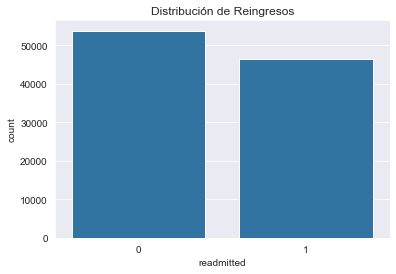

In [7]:
sns.countplot(data=diabetes_df, x='readmitted')
plt.title('Distribución de Reingresos')
plt.show()

In [8]:
features = ["age", "admission_type_id", "discharge_disposition_id", "admission_source_id", "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency", "number_inpatient"]

In [9]:
pipeline_rf = Pipeline([
    ("classifier", RandomForestClassifier(random_state=42))
]) 

In [10]:
param_grid_rf = {
    "classifier__max_depth": [3,4,5,6,7],
    "classifier__min_samples_leaf" : [5, 10, 15],
    "classifier__criterion": ["gini", "entropy", "log_loss"]
}

In [11]:
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=["precision", "recall", "f1"], refit="f1", cv=5, return_train_score=True)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(diabetes_df[features], diabetes_df["readmitted"], test_size=0.3, random_state=1)

In [13]:
grid_rf.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [3, 4, 5, 6, 7],
                         'classifier__min_samples_leaf': [5, 10, 15]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1'])

Text(0.5, 1.0, 'Test')

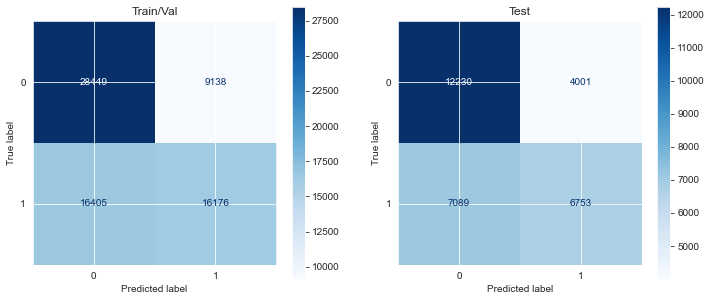

In [14]:
train_val_pred = grid_rf.best_estimator_.predict(X_train)
test_pred = grid_rf.best_estimator_.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(Y_train, train_val_pred, labels=grid_rf.best_estimator_.classes_)
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_rf.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0],  cmap=plt.cm.Blues)
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(Y_test, test_pred, labels=grid_rf.best_estimator_.classes_)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_rf.best_estimator_.classes_)
test_disp.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title("Test")

In [15]:
print("Accuracy:")
print("- Train/Val:", accuracy_score(Y_train, train_val_pred))
print("- Test:", accuracy_score(Y_test, test_pred))
print("\nPrecision:")
print("- Train/Val:", precision_score(Y_train, train_val_pred))
print("- Test:", precision_score(Y_test, test_pred))
print("\nRecall:")
print("- Train/Val:", recall_score(Y_train, train_val_pred))
print("- Test:", recall_score(Y_test, test_pred))
print("\nF1:")
print("- Train/Val:", f1_score(Y_train, train_val_pred))
print("- Test:", f1_score(Y_test, test_pred))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(Y_train, train_val_pred))
print("- Test:", roc_auc_score(Y_test, test_pred))

Accuracy:
- Train/Val: 0.6359736632083001
- Test: 0.6312306720313903

Precision:
- Train/Val: 0.6390139843564826
- Test: 0.6279523898084434

Recall:
- Train/Val: 0.4964856818391087
- Test: 0.48786302557433897

F1:
- Train/Val: 0.5588047327057605
- Test: 0.5491136770206537

ROC AUC:
- Train/Val: 0.6266848554458534
- Test: 0.6206797106800904


In [26]:

# Initializing the model
model_lr = LogisticRegression(penalty="l2", C=0.1, solver="liblinear", class_weight="balanced", random_state=80)
# Training the model using training dataset
model_lr.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight='balanced', random_state=80,
                   solver='liblinear')

Text(0.5, 1.0, 'Test')

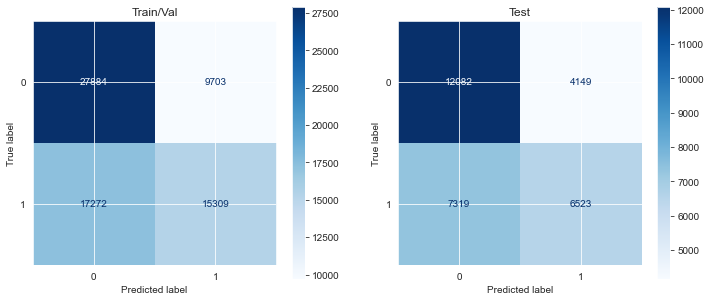

In [27]:
train_val_pred_lr = model_lr.predict(X_train)
test_pred_lr = model_lr.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(Y_train, train_val_pred_lr, labels=model_lr.classes_)
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=model_lr.classes_)
train_val_disp.plot(ax=axes[0],  cmap=plt.cm.Blues)
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(Y_test, test_pred_lr, labels=model_lr.classes_)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_rf.classes_)
test_disp.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title("Test")

In [28]:
print("Accuracy:")
print("- Train/Val:", accuracy_score(Y_train, train_val_pred_lr))
print("- Test:", accuracy_score(Y_test, test_pred))
print("\nPrecision:")
print("- Train/Val:", precision_score(Y_train, train_val_pred_lr))
print("- Test:", precision_score(Y_test, test_pred))
print("\nRecall:")
print("- Train/Val:", recall_score(Y_train, train_val_pred_lr))
print("- Test:", recall_score(Y_test, test_pred))
print("\nF1:")
print("- Train/Val:", f1_score(Y_train, train_val_pred_lr))
print("- Test:", f1_score(Y_test, test_pred))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(Y_train, train_val_pred_lr))
print("- Test:", roc_auc_score(Y_test, test_pred))

Accuracy:
- Train/Val: 0.6155654999429939
- Test: 0.6312306720313903

Precision:
- Train/Val: 0.6120662082200544
- Test: 0.6279523898084434

Recall:
- Train/Val: 0.46987508056842947
- Test: 0.48786302557433897

F1:
- Train/Val: 0.5316271074609762
- Test: 0.5491136770206537

ROC AUC:
- Train/Val: 0.6058636583569527
- Test: 0.6206797106800904


In [29]:
control = grid_rf.best_estimator_
variant = model_lr

In [31]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=control, estimator2=variant, X=X_test, y=Y_test, scoring='recall', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.211, t-Statistic: -1.434


In [43]:
t, p = paired_ttest_5x2cv(estimator1=control, estimator2=variant, X=X_test, y=Y_test, scoring='accuracy', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.000, t-Statistic: 8.409


In [42]:
t, p = paired_ttest_5x2cv(estimator1=control, estimator2=variant, X=X_test, y=Y_test, scoring='precision', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.007, t-Statistic: 4.464


## En términos de recall ambos modelos no tienen diferencias significativas, sin embargo, en precisión y en exactitud son significativamente diferentes

In [39]:
from sklearn.model_selection import train_test_split
xtestA, xtestB, ytestA, ytestB = train_test_split(X_test, Y_test, test_size=0.5)

In [40]:
from sklearn.model_selection import train_test_split
import scipy.stats as stats

ypred_control = control.predict(xtestA)
ypred_variant = variant.predict(xtestB)
acc_control = (ypred_control == ytestA).astype(int)
acc_variante = (ypred_variant == ytestB).astype(int)

print(acc_control.mean())
print(acc_variante.mean())

t_stat, p_value = stats.ttest_rel(acc_control, acc_variante)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

0.6451183825485501
0.6131542195916738


ValueError: unequal length arrays

In [49]:
from sklearn.metrics import classification_report

X_train_gender, X_test_gender, Y_train_gender, Y_test_gender = train_test_split(diabetes_df, diabetes_df["readmitted"], test_size=0.3, random_state=1)
# Separar las predicciones por género
gender_male = Y_train_gender[Y_train_gender['gender'] == 'Male']
gender_female = diabetes_df[diabetes_df['gender'] == 'Female']

gender_male.describe()

,Unnamed: 0,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,46319.000000,4.631900e+04,4.631900e+04,46319.000000,46319.000000,46319.000000,46319.000000,46319.000000,46319.000000,46319.000000,46319.000000,46319.000000,46319.000000,46319.000000,46319.000000,46319.000000
mean,51310.505926,1.667723e+08,5.492537e+07,6.039509,2.045036,3.610268,5.741121,4.325137,43.122822,1.461776,15.929964,0.357024,0.178415,0.621063,7.494095,0.453788
std,29491.787089,1.033230e+08,3.884127e+07,1.474232,1.453988,5.243105,4.113042,2.994653,19.612760,1.797094,8.402740,1.239045,0.780577,1.224797,1.845705,0.497865
min,3.000000,1.668000e+04,1.629000e+03,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,25509.000000,8.513472e+07,2.351201e+07,5.000000,1.000000,1.000000,1.000000,2.000000,32.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,51558.000000,1.535972e+08,4.564934e+07,6.000000,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,76980.500000,2.330215e+08,8.805254e+07,7.000000,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,1.000000
max,101765.000000,4.438672e+08,1.895026e+08,9.000000,8.000000,28.000000,22.000000,14.000000,132.000000,6.000000,81.000000,42.000000,37.000000,19.000000,16.000000,1.000000


In [ ]:
y_pred_gender_male = grid_rf.best_estimator_.predict(gender_male[features])

# Calcular métricas y almacenarlas
fairness_metrics_male = classification_report(
    gender_male, y_pred_gender_male, output_dict=True
)

In [51]:
y_probs = grid_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)

In [52]:
roc_auc = auc(fpr, tpr)

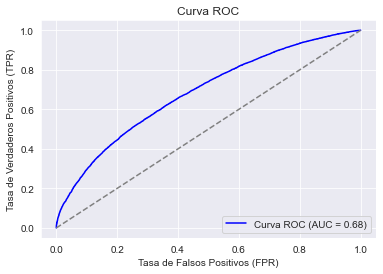

In [53]:
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia (modelo aleatorio)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

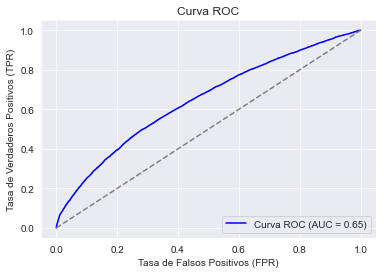

In [54]:
y_probs = model_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia (modelo aleatorio)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [61]:
classification_report(
    Y_test, test_pred, output_dict=True
)

{'0': {'precision': 0.6330555411770795,
  'recall': 0.7534963957858419,
  'f1-score': 0.6880450070323488,
  'support': 16231.0},
 '1': {'precision': 0.6279523898084434,
  'recall': 0.48786302557433897,
  'f1-score': 0.5491136770206537,
  'support': 13842.0},
 'accuracy': 0.6312306720313903,
 'macro avg': {'precision': 0.6305039654927614,
  'recall': 0.6206797106800904,
  'f1-score': 0.6185793420265013,
  'support': 30073.0},
 'weighted avg': {'precision': 0.6307066627397883,
  'recall': 0.6312306720313903,
  'f1-score': 0.6240976964872791,
  'support': 30073.0}}

In [ ]:
protected_attributes = ['race', 'gender']  
 
# Añadir predicciones al conjunto de prueba
X_test_with_attributes = X_test.copy()
X_test_with_attributes['race'] = diabetes_df.loc[X_test.index, 'race']
X_test_with_attributes['gender'] = diabetes_df.loc[X_test.index, 'gender']
X_test_with_attributes['true_label'] = Y_test
X_test_with_attributes['predicted_label'] = predictions
 
# Validar justicia por grupo
for attribute in protected_attributes:
    print(f"\nAnálisis de justicia basado en: {attribute}")
    for group in X_test_with_attributes[attribute].unique():
        group_data = X_test_with_attributes[X_test_with_attributes[attribute] == group]
       
        # Verificar el tamaño del grupo
        print(f"\nGrupo: {group} (Tamaño: {len(group_data)})")
       
        # Matriz de confusión
        cm = confusion_matrix(group_data['true_label'], group_data['predicted_label'])
        print("Matriz de Confusión:")
        print(cm)
       
        # Métricas de clasificación
        report = classification_report(group_data['true_label'], group_data['predicted_label'], zero_division=0)
        print("\nReporte de Clasificación:")
        print(report)

In [66]:
from imblearn.over_sampling import SMOTE, SMOTENC

X = X_train  # Características
Y = Y_train  # Variable objetivo

# Aplicar SMOTE para generar nuevos datos sintéticos
smote = SMOTE(random_state=50)
X_resampled, y_resampled = smote.fit_resample(X, Y)

# Crear un nuevo DataFrame con los datos aumentados
diabetes_df_augmented = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                 pd.DataFrame(y_resampled, columns=["readmitted",])], axis=1)

print("Datos originales:", X.shape)
print("Datos aumentados:", diabetes_df_augmented.shape)

Datos originales: (70168, 11)
Datos aumentados: (75174, 12)


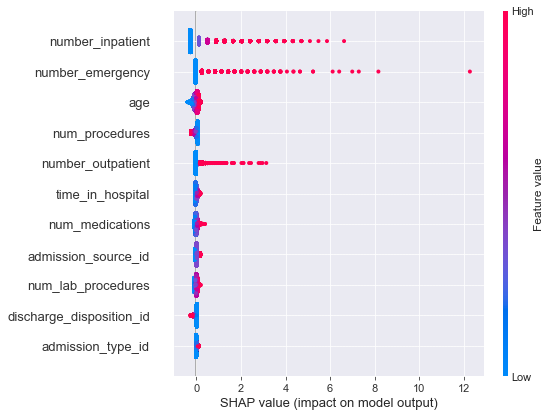

In [72]:
import shap

explainer = shap.Explainer(model_lr, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [71]:
X_test_transformed = pipeline_rf['transformer'].transform(X_test)

# Crear el explainer con el modelo extraído
explainer = shap.Explainer(grid_rf)

# Obtener los valores SHAP
shap_values = explainer.shap_values(X_test_transformed)

# Graficar los valores SHAP
shap.summary_plot(shap_values, X_test_transformed)

KeyError: 'transformer'